In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
time_slot = 5*60*1000 # 5 seconds
length = 10 # number of timeslots around
embedded_size = 30
N = 7

In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/NCKH/IoT/dataset_17-02-2022.csv'
WEIGHTS_PATH = '/content/gdrive/MyDrive/NCKH/IoT/v3_embedding.hdf5'

# Prepare data

Note: Ignore "Load data", "Ignore user" if you use processed data

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df.drop(['id','id_wasp','id_secret','frame_type','frame_number','sync','raw','parser_type','MeshliumID'],axis=1)
df['timestamp'] = list(map(lambda x: int(datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp()),df['timestamp']))
df.head(10)

,sensor,value,timestamp
0,O3,0.20565482974052,1594028407
1,NO2,0,1594028407
2,CO,0.23644705116749,1594028407
3,PRES,100276.1875,1594028407
4,HUM,49.6015625,1594028407
5,TC,25.5,1594028407
6,BAT,58,1594028407
7,O3,0.20122393965721,1594030208
8,NO2,0,1594030208
9,CO,0.16477552056313,1594030208


In [ ]:
lst_sensor = list(set(df['sensor']))
lst_sensor.remove('WV')
len(lst_sensor)

16

In [ ]:
import math

start_time = min(df.timestamp)
end_time = max(df.timestamp)
num_of_slots = math.ceil((end_time-start_time)/time_slot)
start_time,end_time,num_of_slots

(1594027700, 1623141813, 98)

In [ ]:
import more_itertools as mit

X_idx = []
y = []

maximum_value = {}
start_end = {}
normalized_df = pd.DataFrame(columns=df.columns)

for sensor in lst_sensor:
  subdf = df[df.sensor == sensor]
  history = subdf.value.astype(np.float32)
  history[history < 0] = 0
  maximum_value[sensor] = np.max(history)
  y.extend(history[N:]/maximum_value[sensor])
  history = (history/maximum_value[sensor] * 100).astype(int)
  X_idx.extend(list(mit.windowed(history, n=N, step=1))[:-1])
  
  subdf.value = history
  normalized_df = normalized_df.append(subdf)

df = normalized_df
X = np.array(X_idx)
y = np.array(y)
X.shape, y.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


((486295, 10), (486295,))

In [ ]:
#y = y * 100
y

array([0.99510735, 0.9953993 , 0.99565101, ..., 0.47567806, 0.56625885,
       0.54562199])

In [ ]:
maximum_value

{'ANE': 40.79999923706055,
 'B': 45.0,
 'BAT': 100.0,
 'CO': 11.349579811096191,
 'HUM': 100.0,
 'LUX': 21010.0,
 'NO2': 0.17887425422668457,
 'NOISE': 73.00460052490234,
 'O3': 0.4146099388599396,
 'PLV1': 107.56999969482422,
 'PLV2': 46.380001068115234,
 'PLV3': 102.54000091552734,
 'PM10': 10.100000381469727,
 'PM25': 8.800000190734863,
 'PRES': 100939.109375,
 'TC': 43.7599983215332}

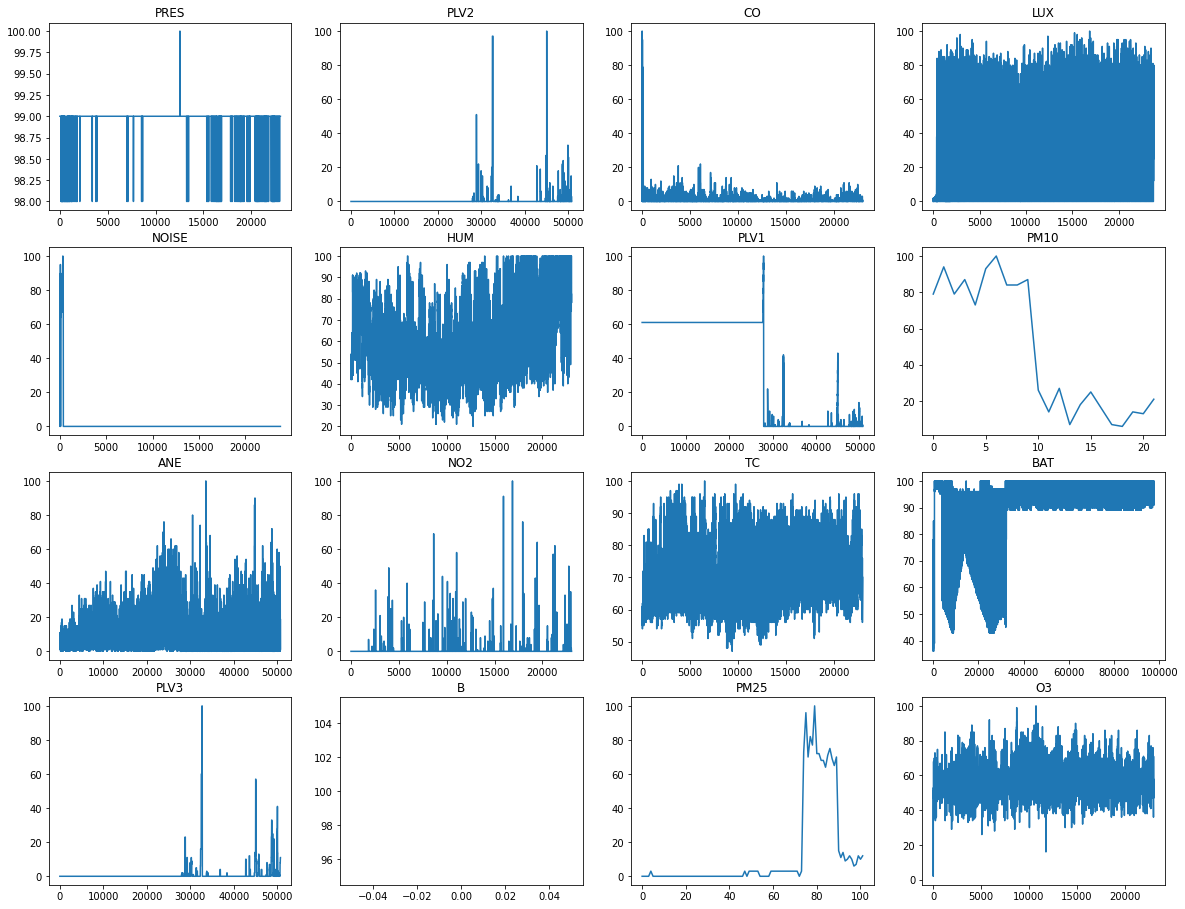

In [ ]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(20,20))

for i,sensor in enumerate(lst_sensor,start=1):
    yy = df[df.sensor==sensor].value
    xx = range(len(yy))
    
    f.add_subplot(5,4,i)
    plt.plot(xx,yy)
    plt.title(sensor)

### generate

In [ ]:
len(lst_sensor)

16

In [ ]:
import more_itertools as mit
from google.colab import output
from functools import reduce

In [ ]:

X_item2vec = []
# X = []
# y = []

#is_exists = np.zeros(num_of_items,)

def onehot(x):
  #x: int
  lst = [0]*100
  lst[x] = 1
  return lst

def removeNul(x):
  #(1,2,-1,3,-1,2) -> (1,2,3,2)
  res = []
  return [str(i) for i in x if (i != -1)]

def flatten(x):
  #[[1],[2,1,3],[2]] -> [1,2,1,3,2]
  return [str(i) for c in x for i in c]

all_values = set()

for sensor in lst_sensor:
  subdf = df[df.sensor == sensor]

  # train_data for Item2Vec
  idx = ((subdf.timestamp - start_time) // time_slot).to_numpy()[:-1]
  values = subdf.value
  series = [[] for _ in range(num_of_slots)]
  for id,value in zip(idx,values):
    series[id].append(value)

  temp = list(mit.windowed(series, n=length, step=1))[:-1]  
  new_row = list(map(flatten,temp))
  X_item2vec.extend(new_row)
  
  for i in new_row: 
    all_values = all_values.union(i)


  # data for MLP
  # history = list(map(lambda x: hash_itemID[x],subdf.itemID))
  # new_x = list(mit.windowed(history, n=N, step=1))[:-1]
  # X.extend(new_x)
  # y.extend(list(map(onehot,history[N:])))

  # sensor = 'ANE'
  # X = np.array(X[start_end[sensor][0]:start_end[sensor][1]])
  # y = np.array(y[start_end[sensor][0]:start_end[sensor][1]])
  # y = y/100
  # X.shape, y.shape

In [ ]:
all_values

{'0',
 '1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99'}

In [ ]:
#######################################
# CHECK IF THIS VALUE IS EQUAL TO 101 #
#######################################
len(all_values)
X_item2vec[:20]

[['99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99'],
 ['99'],
 ['99'],
 ['99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99'],
 ['99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99'],
 ['99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99'],
 ['99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99'],
 ['99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99'],
 ['99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99',
  '99'],
 ['99',

In [ ]:
from gensim.models import Word2Vec
#CBOW model
vecs = Word2Vec(X_item2vec, min_count=1, size=embedded_size, window=5, sg=0)

In [ ]:
vecs['31']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 2.0540123 ,  0.36566833,  1.6939704 ,  1.2322017 ,  0.918333  ,
        0.6067467 , -1.220883  ,  0.13275516, -1.3361373 ,  0.85844636,
        0.40777797, -0.14648508,  1.3608029 , -1.2329993 , -3.825911  ,
        1.8751765 , -1.7025461 , -0.5257584 , -0.70297635, -0.5730566 ,
       -0.8428764 , -0.23186453, -0.13649024, -0.37544107, -0.20540679,
        2.1816308 , -0.16414356, -0.5863553 , -1.3623514 ,  0.44782385],
      dtype=float32)

In [ ]:
vecs.similar_by_vector(vecs['31'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('31', 1.0000001192092896),
 ('29', 0.7888698577880859),
 ('33', 0.7868273258209229),
 ('30', 0.7834762334823608),
 ('32', 0.754564642906189),
 ('25', 0.7392369508743286),
 ('27', 0.7221088409423828),
 ('34', 0.6812295913696289),
 ('35', 0.6726160645484924),
 ('23', 0.6218706369400024)]

#### split train-test

In [ ]:
def mapping(x):
  #x = (1,2,3) -> (vect(1),vect(2),vect(3))
  return [vecs[str(i)] for i in x]

In [ ]:
X = np.array(list(map(mapping,X)))
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
y = y.reshape(len(y),1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [ ]:
print(X_train[10],y_train[10],sep='\n\n')

[[ 0.8452548   0.263222   -3.1630845  -1.7602849  -2.050364   -1.2561816
   0.98759276  0.71425265 -0.34229836 -1.1871005  -0.10244417  0.09055544
   0.03146761 -0.7493831  -0.25747898  3.4122996   1.1827147  -0.29459596
   2.1814322  -1.6631757  -1.5751137  -2.8267407  -2.3142111   0.33876342
  -0.29894462 -0.05527525  0.76009095  0.47266325  0.34305203  0.81498575]
 [ 0.49226567  0.63860977 -0.94532937  1.2869937   1.2061521  -0.10731968
  -0.00991438  0.98165405 -0.59149104 -0.9145856  -1.0349033   2.2203107
   0.31107357  0.7701115   2.8664238  -0.24161287  0.805375    2.4995418
   2.5762377  -0.03516895  0.3580068   0.80313116 -2.3869326  -0.12245694
   3.572444   -0.6810145   0.80243576  1.5365663  -0.8540897  -2.6700773 ]
 [ 0.00853953 -0.516101   -1.0248878  -1.8479445  -1.2575415  -0.30435246
  -1.0069774  -1.9634781  -2.705974   -2.0799441   0.7387819  -1.0632944
  -0.09202024  1.5142074  -1.3173054  -0.74840784 -0.18741769  3.6576805
   3.8050358  -0.5946895  -2.4363317  -0.

In [ ]:
X_train.shape, y_train.shape

((340406, 10, 30), (340406, 1))

# MLP

In [ ]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import tensorflow as tf 
from sklearn.metrics import mean_squared_error

model = Sequential()

model.add(InputLayer((N,embedded_size)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
"""
input_raw = Input((N,embedded_size))
flatten = Flatten()(input_raw)

hidden = Dense(64, activation='relu')(flatten)
y_pred = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs = input_raw, outputs = y_pred)
"""
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                19264     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,329
Trainable params: 19,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lrate = 1e-4
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer=opt, loss=root_mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=10, monitor='val_loss')
history = model.fit(X_train,y_train,batch_size=128,epochs=1000,verbose=True, callbacks=[early_stop,model_checkpoint])

Epoch 1/1000
2660/2660 [==============================] - 7s 2ms/step - loss: 0.0759 - accuracy: 0.4202
Epoch 2/1000
2660/2660 [==============================] - 8s 3ms/step - loss: 0.0485 - accuracy: 0.4207
Epoch 3/1000
2660/2660 [==============================] - 7s 2ms/step - loss: 0.0436 - accuracy: 0.4207
Epoch 4/1000
2660/2660 [==============================] - 7s 2ms/step - loss: 0.0413 - accuracy: 0.4207
Epoch 5/1000
2660/2660 [==============================] - 6s 2ms/step - loss: 0.0400 - accuracy: 0.4207
Epoch 6/1000
2660/2660 [==============================] - 6s 2ms/step - loss: 0.0391 - accuracy: 0.4207
Epoch 7/1000
2660/2660 [==============================] - 7s 3ms/step - loss: 0.0384 - accuracy: 0.4207
Epoch 8/1000
2660/2660 [==============================] - 6s 2ms/step - loss: 0.0379 - accuracy: 0.4207
Epoch 9/1000
2660/2660 [==============================] - 6s 2ms/step - loss: 0.0374 - accuracy: 0.4207
Epoch 10/1000
2660/2660 [==============================] - 6s 2m

Text(0.5, 1.0, 'lrate=0.0001')

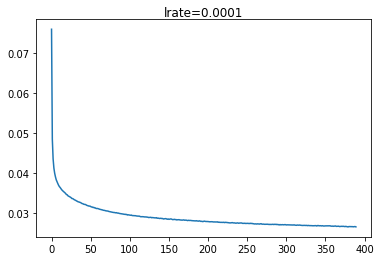

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.title('lrate='+str(lrate), pad=-50)

In [ ]:
model.save_weights(WEIGHTS_PATH)

In [ ]:
model.load_weights(WEIGHTS_PATH)

In [ ]:
rmse_model = model.evaluate(X_test, y_test)
print("Root Mean Square Error of Model = {}".format(rmse_model))

4560/4560 [==============================] - 7s 1ms/step - loss: 0.0386 - accuracy: 0.4190
Root Mean Square Error of Model = [0.03862862288951874, 0.4190446138381958]


In [ ]:
y_pred = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_pred,y_test))

print("RMSE of testset = {}".format(rmse))

RMSE of testset = 0.04689325252206662


In [ ]:
yyyy = y_pred.flatten()

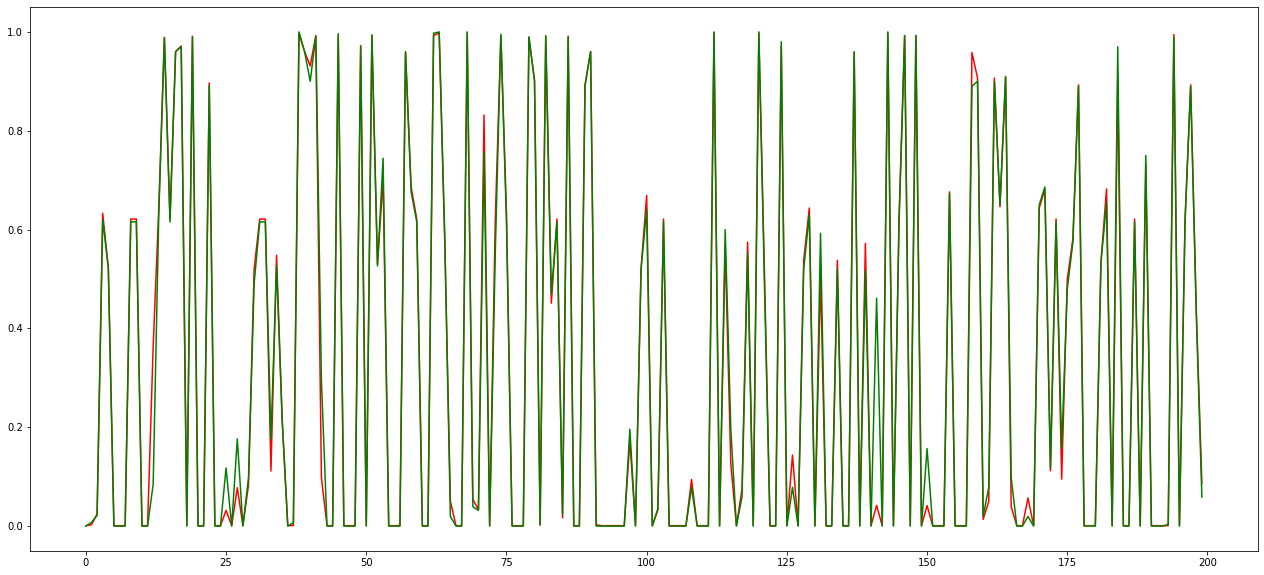

In [ ]:
ar = np.arange(len(yyyy[:200]))
plt.figure(figsize=(22,10))
plt.plot(ar, yyyy[:200],'r')
plt.plot(ar, y_test[:200],'g')
plt.show()

In [ ]:
#wrapper
def process(sensor, inp):
  #sensor: sensor id
  #x: array/ndarray of N value in the past
  inp = (np.array(inp)/maximum_value[sensor]*100).astype(int)
  inp = np.array([vecs[str(i)] for i in inp])
  out = model.predict(np.array([inp]))
  out = out*maximum_value[sensor]

  return out[0][0]

## Infer

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df.drop(['id','id_wasp','id_secret','frame_type','frame_number','sync','raw','parser_type','MeshliumID'],axis=1)

idx = 33586
arr = df[df.sensor=='ANE'].value.to_numpy().astype(np.float32)
print("SAMPLE INPUT: ",end='')
print(', '.join(arr[idx:idx+N].astype(str)))
print("EXPECT: ",end='')
print(arr[idx+N])

SAMPLE INPUT: 2.4, 5.6, 3.2, 23.2, 15.2, 40.8, 4.0, 5.6, 4.8, 2.4
EXPECT: 4.0


In [ ]:
process('ANE',arr[idx:idx+N])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


3.2442136